In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("csv-files/Kitchener_Price_Trend.csv")
df = df.drop(['City'], axis=1)
df

,Price,timestamp
0,596354,2023-11-06 00:00:00
1,587193,2023-11-08 00:00:00
2,572194,2023-11-10 00:00:00
3,568798,2023-11-12 00:00:00
4,560863,2023-11-22 00:00:00
...,...,...
61,523995,2024-03-26 00:00:00
62,509577,2024-03-28 00:00:00
63,504414,2024-03-31 00:00:00
64,516741,2024-04-03 00:00:00


In [2]:
df.index = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df

,Price,timestamp
timestamp,,
2023-11-06,596354,2023-11-06 00:00:00
2023-11-08,587193,2023-11-08 00:00:00
2023-11-10,572194,2023-11-10 00:00:00
2023-11-12,568798,2023-11-12 00:00:00
2023-11-22,560863,2023-11-22 00:00:00
...,...,...
2024-03-26,523995,2024-03-26 00:00:00
2024-03-28,509577,2024-03-28 00:00:00
2024-03-31,504414,2024-03-31 00:00:00


<Axes: xlabel='timestamp'>

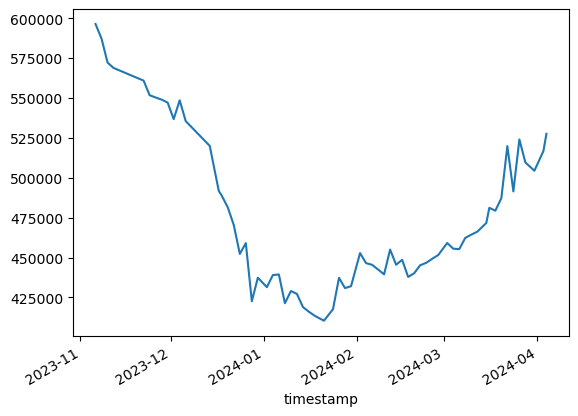

In [3]:
price = df['Price']
price.plot()

In [113]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [114]:
WINDOW_SIZE = 5
X, y = df_to_X_y(price, WINDOW_SIZE)

In [115]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the input data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
Y_scaled = scaler.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

In [116]:
X_scaled.shape, Y_scaled.shape

((61, 5, 1), (61,))

In [143]:
sixty_percent = round(Y_scaled.size*0.6)
eighty_percent = round(Y_scaled.size*0.8)
x_train, y_train = X_scaled[:sixty_percent], Y_scaled[:sixty_percent]
x_valid, y_valid = X_scaled[sixty_percent:eighty_percent], Y_scaled[sixty_percent:eighty_percent]
x_test, y_test = X_scaled[eighty_percent:], Y_scaled[eighty_percent:]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((37, 5, 1), (37,), (12, 5, 1), (12,), (12, 5, 1), (12,))

In [118]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [119]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

def train_model(x_train, y_train, lstm_num_nodes, dropout, num_nodes, learning_rate, batch_size, epochs):
    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(LSTM(lstm_num_nodes, return_sequences=True, dropout=dropout))
    model.add(Dense(num_nodes, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    cp = ModelCheckpoint('./model.keras', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), 
                metrics=[RootMeanSquaredError()])
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                epochs=epochs, batch_size=batch_size, callbacks=[cp], verbose=0)
    return model, history

In [120]:
import matplotlib.pyplot as plt


def plot_history(history):
    # Figure Configuration to show two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    # Plot one to visualize the loss from the history
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Squared Error')
    ax1.grid(True)
    # Plot two to visualize the root mean squared error from the history
    ax2.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    ax2.plot(history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('root_mean_squared_error')
    ax2.grid(True)
    plt.show()

In [173]:
# Iterating over different set of hyperparameters 
# combination to find the optimal set of hyperparameters

# We initialize it as infinity knowing that 
# any model will beat that score
#least_val_loss = float('inf')
# Initializing the least loss model variable
#least_loss_model = None

#for lstm_num_nodes in [32, 64, 128]:
  #for num_nodes in [16, 32, 64]:
    #for dropout_prob in [0, 0.2]:
      #for epochs in [10, 20, 30]:
        #for learning_rate in [0.1, 0.005, 0.001]:
          #for batch_size in [16, 32, 64]:
            #model, history = train_model(x_train, y_train, lstm_num_nodes, dropout_prob, 
                                         #num_nodes, learning_rate, batch_size, epochs)
            #print(f'''Number Of Nodes: {num_nodes}, Dropout: {dropout_prob}, 
                  #Learning Rate: {learning_rate}, Batch Size: {batch_size}''')
            #plot_history(history)
            # Check the validation dataset loss is with different hyperparameters
            #val_loss = model.evaluate(x_valid, y_valid)[0]
            #if val_loss < least_val_loss:
              #least_val_loss = val_loss
              #least_loss_model = model
            #print(f'Validation Loss of this model: {val_loss}')
            #print('################### END ###################\n')

In [149]:
#from tensorflow.keras.models import load_model
#model = load_model('./model.keras')

In [174]:
model, history = train_model(x_train, y_train, 128, 0, 
                                         64, 0.001, 4, 20)

Model: "sequential_712"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_711 (LSTM)                 │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1422 (Dense)              │ (None, 5, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1423 (Dense)              │ (None, 5, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,881 (292.50 KB)

 Trainable params: 74,881 (292.50 KB)

 Non-trainable params: 0 (0.00 B)

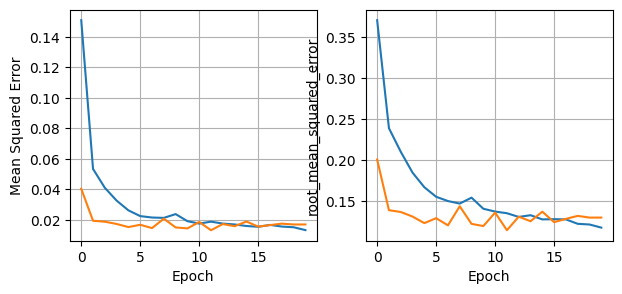

In [175]:
 plot_history(history)

In [176]:
y_train = y_train.reshape(y_train.shape[0], -1)
train_predict = model.predict(y_train)
train_predict_reshape = train_predict.reshape(1, -1)
train_predict_result = scaler.inverse_transform(train_predict_reshape)

y_train_reshape = y_train.reshape(1, -1)
y_train_result = scaler.inverse_transform(y_train_reshape)
train_results = pd.DataFrame(data={'Train Predictions':train_predict_result.flatten(), 'Actuals':y_train_result.flatten()})
train_results

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


,Train Predictions,Actuals
0,511521.96875,551700.0
1,509880.40625,548971.0
2,508744.12500,547080.0
3,502533.03125,536752.0
4,509610.53125,548522.0
5,501764.68750,535502.0
6,491930.43750,519975.0
7,474249.37500,491803.0
8,472356.75000,488761.0
9,467821.59375,481450.0


In [177]:
y_valid = y_valid.reshape(y_valid.shape[0], -1)
valid_predict = model.predict(y_valid)
valid_predict_reshape = valid_predict.reshape(1, -1)
valid_predict_result = scaler.inverse_transform(valid_predict_reshape)

y_valid_reshape = y_valid.reshape(1, -1)
y_valid_result = scaler.inverse_transform(y_valid_reshape)
valid_results = pd.DataFrame(data={'Valid Predictions':valid_predict_result.flatten(), 'Actuals':y_valid_result.flatten()})
valid_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Valid Predictions,Actuals
0,448076.43750,449239.0
1,449501.18750,451585.0
2,454100.15625,459134.0
3,451921.90625,455563.0
4,451760.46875,455298.0
5,456052.00000,462327.0
6,457298.56250,464363.0
7,458430.81250,466210.0
8,461779.78125,471661.0
9,467640.84375,481158.0


In [178]:
y_test = y_test.reshape(y_test.shape[0], -1)
test_predict = model.predict(y_test)
test_predict_reshape = test_predict.reshape(1, -1)
test_predict_result = scaler.inverse_transform(test_predict_reshape)

y_test_reshape = y_test.reshape(1, -1)
y_test_result = scaler.inverse_transform(y_test_reshape)
test_results = pd.DataFrame(data={'Test Predictions':test_predict_result.flatten(), 'Actuals':y_test_result.flatten()})
test_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


,Test Predictions,Actuals
0,447686.31250,448596.0
1,510257.96875,549599.0
2,431752.96875,419005.0
3,430258.18750,416022.0
4,471379.96875,487189.0
5,491829.87500,519816.0
6,474039.56250,491466.0
7,494475.25000,523995.0
8,485372.93750,509577.0
9,482130.50000,504414.0


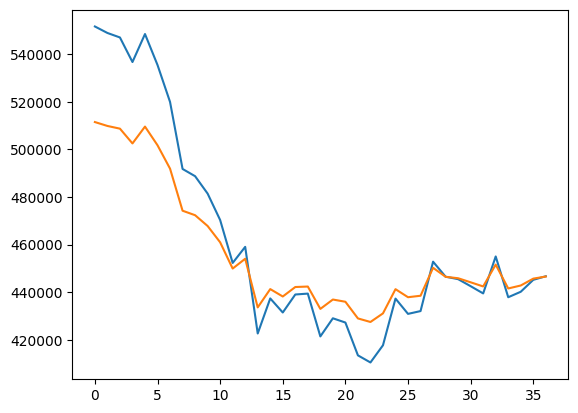

In [179]:
plt.plot(train_results['Actuals'])
plt.plot(train_results['Train Predictions'])

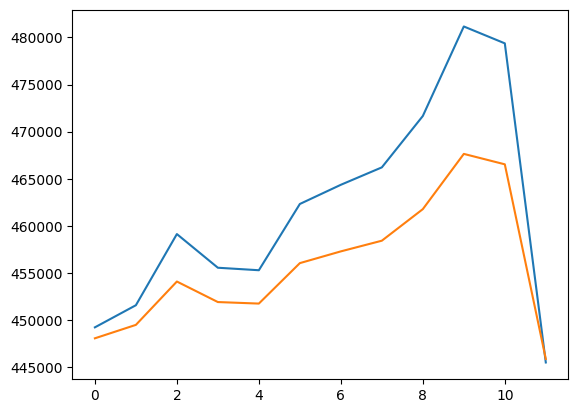

In [180]:
import matplotlib.pyplot as plt

plt.plot(valid_results['Actuals'])
plt.plot(valid_results['Valid Predictions'])

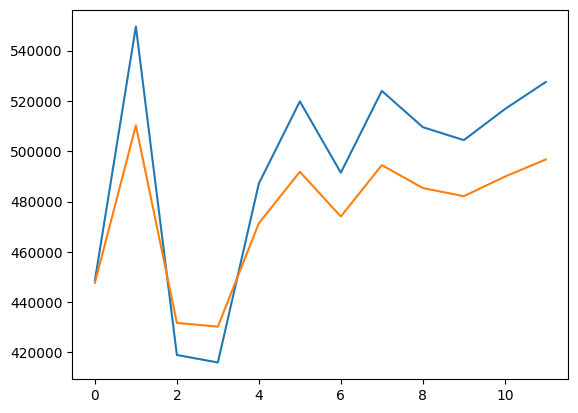

In [181]:
import matplotlib.pyplot as plt

plt.plot(test_results['Actuals'])
plt.plot(test_results['Test Predictions'])